This notebook is based off of Fatima's `peak_fit_trend_SFR.ipynb` notebook and is designed to compute and plot the SFR as a function of depth inside the V$^2$ voids.

This analysis requires binning the V$^2$ galaxies by their normalized depth inside a void and fitting the resulting distirbution in SFR.  We then compute the ratio of the means of the two skew normal distributions at each depth value.

In [15]:
import numpy as np

from astropy.table import Table
from astropy.io import fits

from scipy.optimize import curve_fit, minimize_scalar
from scipy.stats import skewnorm

from functions import model_skew, estimate_Jacobian

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# Data

In [3]:
filename = '../../../../data/NSA_v1_0_1_VAGC_vflag-V2-VF.fits'

hdul = fits.open(filename)
data = Table(hdul[1].data)
hdul.close()

## Just keep the main SDSS DR7 footprint

In [4]:
# When the catalog is the NSA, only keep those objects which were originally in the DR7 LSS
catalog_SDSS = data[data['IN_DR7_LSS'] == 1]

ra_boolean = np.logical_and(catalog_SDSS['RA'] > 110, catalog_SDSS['RA'] < 270)
catalog_north = catalog_SDSS[ra_boolean]

strip_boolean = np.logical_and.reduce([catalog_north['RA'] > 250, 
                                       catalog_north['RA'] < 269, 
                                       catalog_north['DEC'] > 51, 
                                       catalog_north['DEC'] < 67])
catalog_main = catalog_north[~strip_boolean]

In [5]:
# Also only keep those within the redshift limit of the void catalogs
vollim = catalog_main[catalog_main['Z'] <= 0.114]

## Separate galaxies by their LSS classifications

### $V^2$

In [6]:
wall_v2 = catalog_main['vflag_V2'] == 0
void_v2 = catalog_main['vflag_V2'] == 1
edge_v2 = catalog_main['vflag_V2'] == 2
out_v2 = catalog_main['vflag_V2'] == 9

### VoidFinder

In [7]:
wall_vf = catalog_main['vflag_VF'] == 0
void_vf = catalog_main['vflag_VF'] == 1
edge_vf = catalog_main['vflag_VF'] == 2
out_vf = catalog_main['vflag_VF'] == 9

# SFR as a function of void depth

Bin the V$^2$ void galaxies by how far from their void boundary they are, and plot the ratio of the high SFR peak mean to the low SFR peak mean in that bin as a function of the distance from the void boundary.  The plot will be cumulative from the inside of a void out, so we are really trying to find the "true" void galaxy population using V$^2$.

In [8]:
def func_bimodal(x, a, mua, sga, askew, b, mub, sgb, bskew):
    """
    Mixture of two skew normal distributions.
    

    Parameters
    ----------

    x : float or ndarray
        Values to calculate the model.
        
    a, b : float
        amplitudes of the skew normal distributions
        
    mua, mub : float
        locations of the skew normal distributions
        
    sga, sgb : float
        widths of the skew normal distributions
        
    askew, bskew : float
        skews of the skew normal distributions
    

    Returns
    -------
    model : float or ndarray
        Mixture model evaluated at x.
    """

    return a*skewnorm.pdf(x, askew, loc=mua, scale=sga) + \
           b*skewnorm.pdf(x, bskew, loc=mub, scale=sgb)

In [9]:
def bin_data(data, bins_, label="label me", plot=False): 

    n1, edges1 = np.histogram(data, bins=bins_)

    dn1 = np.sqrt(n1)

    x = 0.5*(edges1[1:] + edges1[:-1])
        
    if plot:
        plt.errorbar(x, n1, yerr=dn1, fmt='.')        
        plt.xlabel(label, fontsize=18)
        plt.ylabel('count',fontsize=18) 
        plt.title(label)
        plt.show()
        
    return  x, n1, dn1 #, popt_void

In [10]:
def fit_bimodal(char_, bins, class_=None, p0_=None, err=None, label=''):
    
    if class_ is None:
        x_data, y_data, dy = bin_data(data=char_, bins_=bins)
    else:
        x_data, y_data, dy = bin_data(data=char_[class_], bins_=bins)   
    
    if err is None:
        err = dy
    else:
        err[np.argwhere(err==0)] = 0.00001
    
    popt_, pcov_ = curve_fit(func_bimodal, x_data, y_data, p0=p0_)#, sigma=s)#, sigma=cov)
    
    ############################################################################
    # Plot distribution and best fit
    #---------------------------------------------------------------------------
    plt.errorbar(x_data, y_data, yerr=err, fmt='.')  
    plt.plot(x_data, func_bimodal(x_data, *popt_), 'k')
    plt.plot(x_data, model_skew(popt_[:4], x_data), 'b')
    plt.plot(x_data, model_skew(popt_[4:], x_data), 'r')
    plt.ylabel('Counts')
    plt.title(label)
    plt.show()
    ############################################################################
    
    print(popt_, np.sqrt(np.diag(pcov_)))
    
    #return popt_, np.sqrt(np.diag(pcov_))
    return popt_, pcov_

In [11]:
def ratio_uncertainty(fit, cov, x1, x2):
    '''
    Compute the uncertainty in the ratio of one peak to the other of the best-fit function.
    
    
    PARAMETERS
    ==========
    
    fit : list of length n
        Values of the best-fit parameters for the fit
        
    cov : ndarray of shape (n,n)
        Covariance matrix corresponding to the n best-fit parameters.
        
    x1, x2 : float
        The two x positions at which the best-fit function is evaluated for the ratio.  
        x1 is the value for the numerator of the ratio, and x2 is the value for the 
        denominator.
        
        
    RETURNS
    =======
    
    ratio_err : float
        Uncertainty in the ratio of the peaks in the best-fit.
    '''
    
    # Calculate the value of the best-fit function at x1, x2
    f1 = func_bimodal(x1, *fit)
    f2 = func_bimodal(x2, *fit)
    
    # Calculate the ratio
    ratio = f1/f2
    
    # Estimate the Jacobian of the best-fit function at x1, x2
    Jf1 = estimate_Jacobian(func_bimodal, x1, fit)
    Jf2 = estimate_Jacobian(func_bimodal, x2, fit)
    
    # Calculate the uncertainty of the best-fit-function at x1, x2
    df1 = Jf1.T@cov@Jf1
    df2 = Jf2.T@cov@Jf2
    
    # Calculate the normalized uncertainty in the ratio
    dr_norm = (df1/f1)**2 + (df2/f2)**2
    
    # Calculate the uncertainty in the ratio
    ratio_err = ratio*np.sqrt(dr_norm)
    
    return ratio_err

In [32]:
def ratio_uncertainty_approx(fit, cov, x1, x2):
    '''
    Compute the uncertainty in the ratio of one peak to the other of the 
    best-fit function by randomly sampling the best-fit parameters based 
    on their covariance matrix.
    
    
    PARAMETERS
    ==========
    
    fit : list of length n
        Values of the best-fit parameters for the fit
        
    cov : ndarray of shape (n,n)
        Covariance matrix corresponding to the n best-fit parameters.
        
    x1, x2 : float
        The two x positions at which the best-fit function is evaluated for the ratio.  
        x1 is the value for the numerator of the ratio, and x2 is the value for the 
        denominator.
        
        
    RETURNS
    =======
    
    ratio_mean : float
        Estimated mean in the ratio of the peaks in the best-fit.
    
    ratio_std : float
        Estimated uncertainty in the ratio of the peaks in the best-fit.
    '''
    
    # Generate a large number of random samples of the best-fit parameters
    random_params = np.random.default_rng().multivariate_normal(fit, cov, 5000).T
    
    # Calculate the value of the function at x1, x2 for each of these parameter sets
    f1_random = func_bimodal(x1, 
                             random_params[0], 
                             random_params[1], 
                             random_params[2], 
                             random_params[3], 
                             random_params[4], 
                             random_params[5], 
                             random_params[6], 
                             random_params[7])
    f2_random = func_bimodal(x2, 
                             random_params[0], 
                             random_params[1], 
                             random_params[2], 
                             random_params[3], 
                             random_params[4], 
                             random_params[5], 
                             random_params[6], 
                             random_params[7])
    
    # Calculate the ratio of f1/f2 for each of these parameter sets
    ratio_random = f1_random/f2_random
    
    # Calculate the mean and standard deviation of this distribution
    ratio_mean = np.nanmean(ratio_random)
    ratio_std = np.nanstd(ratio_random)
    
    return ratio_mean, ratio_std

# How does the SFR amplitude ratio depend on depth in the V$^2$ voids?

In [13]:
SFR_bins = np.linspace(-3, 2, 250)

## Full sample

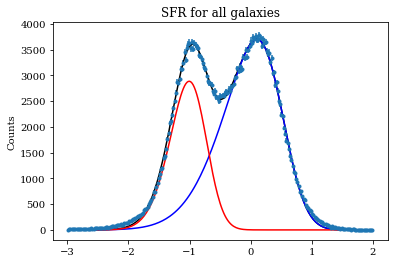

[ 4.53957400e+03  4.91753092e-01  7.53624750e-01 -2.26571826e+00
  2.17894688e+03 -7.84217314e-01  4.08767082e-01 -1.46089471e+00] [6.85205036e+01 8.69517194e-03 2.41242815e-02 1.32212701e-01
 6.72551794e+01 6.46099440e-03 6.43687457e-03 8.30876965e-02]


In [16]:
SFR_all_fit = fit_bimodal(char_=vollim['SFR'],
                          bins=SFR_bins, 
                          p0_=[4000, 0.5, 0.75, -2.25, 2000, -0.75, 0.5, -1.5], 
                          label='SFR for all galaxies')

In [33]:
blue_all = minimize_scalar(lambda x: -func_bimodal(x, *SFR_all_fit[0]), bounds=(-0.5,2), method='bounded')
red_all = minimize_scalar(lambda x: -func_bimodal(x, *SFR_all_fit[0]), bounds=(-2, -0.5), method='bounded')

#SFR_ratio_all = SFR_all_fit[0][0]/SFR_all_fit[0][4]
#SFR_ratio_all = model_max(SFR_all_fit[0][:4])/model_max(SFR_all_fit[0][4:])
SFR_ratio_all = blue_all.fun/red_all.fun
print(SFR_ratio_all)

SFR_ratio_all_approx, SFR_ratio_all_err = ratio_uncertainty_approx(SFR_all_fit[0], 
#SFR_ratio_all_err = ratio_uncertainty(SFR_all_fit[0], 
                                                                   SFR_all_fit[1], 
                                                                   blue_all.x, 
                                                                   red_all.x)
print(SFR_ratio_all_approx, SFR_ratio_all_err)
#print(SFR_ratio_all_err)

1.025887833393667
1.0260282748464655 0.006238114080865557


## VoidFinder void

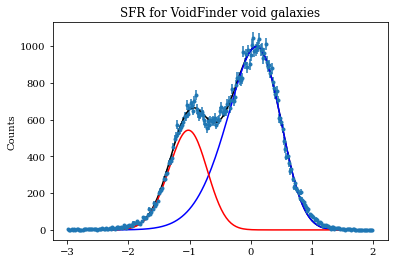

[ 1.10980762e+03  4.39048505e-01  6.44527860e-01 -1.84054268e+00
  4.28412156e+02 -8.28920338e-01  3.80940445e-01 -9.64346565e-01] [2.96893901e+01 1.81254736e-02 4.02659658e-02 2.18632516e-01
 2.95884294e+01 2.90308222e-02 2.03777513e-02 2.71214037e-01]


In [18]:
SFR_VF_fit = fit_bimodal(char_=catalog_main['SFR'],
                         class_=void_vf,
                         bins=SFR_bins, 
                         p0_=[4000, 0.5, 0.75, -2.25, 2000, -0.75, 0.5, -1.5], 
                         label='SFR for VoidFinder void galaxies')

In [34]:
blue_VF = minimize_scalar(lambda x: -func_bimodal(x, *SFR_VF_fit[0]), bounds=(-0.5,2), method='bounded')
red_VF = minimize_scalar(lambda x: -func_bimodal(x, *SFR_VF_fit[0]), bounds=(-2, -0.5), method='bounded')

SFR_ratio_VF = blue_VF.fun/red_VF.fun
print(SFR_ratio_VF)

SFR_ratio_VF_approx, SFR_ratio_VF_err = ratio_uncertainty_approx(SFR_VF_fit[0], 
#SFR_ratio_VF_err = ratio_uncertainty(SFR_VF_fit[0], 
                                                                 SFR_VF_fit[1], 
                                                                 blue_VF.x, 
                                                                 red_VF.x)
print(SFR_ratio_VF_approx, SFR_ratio_VF_err)
#print(SFR_ratio_VF_err)

1.5014289444542142
1.49778241023588 0.01639466370080296


## V$^2$ voids

6380


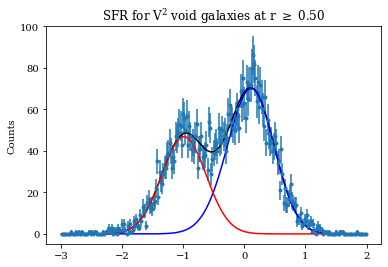

[ 6.72200415e+01  3.16482211e-01  4.43093785e-01 -8.00689934e-01
  4.26294583e+01 -9.86882907e-01  3.62875649e-01 -2.01255019e-05] [8.29921132e+00 2.26931760e-01 1.92358235e-01 1.23064877e+00
 8.27390681e+00 1.36874798e+03 1.15189749e+01 4.72803691e+03]
12636


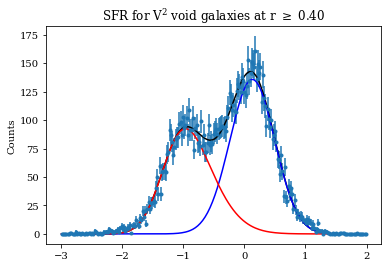

[ 1.25071342e+02  1.31827823e-01  3.67573184e-01 -1.81237701e-03
  9.39013803e+01 -1.27159086e+00  5.71167466e-01  1.66121727e+00] [8.35153200e+00 4.79985090e+02 6.93027716e-01 1.63660554e+03
 8.00657567e+00 5.39767789e-02 1.10179770e-01 6.30361481e-01]
20721


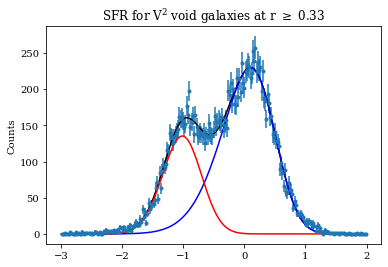

[253.10565038   0.4432581    0.63171367  -1.77482301 107.75583377
  -0.84439703   0.36811192  -0.79917367] [12.51778477  0.0341914   0.07352697  0.39583182 12.47566546  0.07448037
  0.04287326  0.55838874]
31104


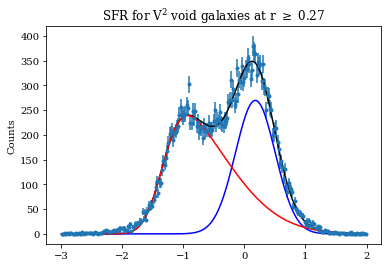

[ 2.20689783e+02  1.81905870e-01  3.26274724e-01 -4.45308183e-03
  3.26167618e+02 -1.33253302e+00  9.38538055e-01  3.73879821e+00] [1.18962872e+01 5.60737703e+02 3.16160888e+00 2.15405285e+03
 1.32616073e+01 1.04736638e-02 5.29289728e-02 3.47965846e-01]
44538


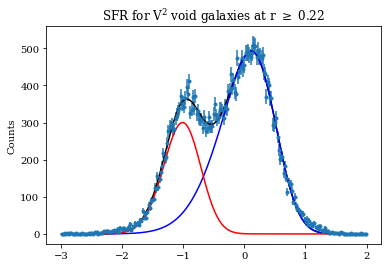

[ 5.54343204e+02  4.67023965e-01  6.65388385e-01 -1.97011759e+00
  2.30262575e+02 -8.21533423e-01  3.73099791e-01 -9.96578858e-01] [16.82671783  0.01993271  0.04656985  0.26114598 16.70064262  0.03073527
  0.0220262   0.29137357]
62095


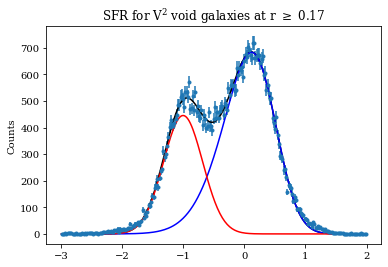

[ 7.39865678e+02  4.50365338e-01  6.14022057e-01 -1.71304774e+00
  3.58967823e+02 -9.98522642e-01  3.21389825e-01 -1.07637570e-02] [2.87789595e+01 2.48571228e-02 5.40445298e-02 2.85785676e-01
 2.87279433e+01 5.92716218e+02 3.90441413e+00 2.31165794e+03]
85110


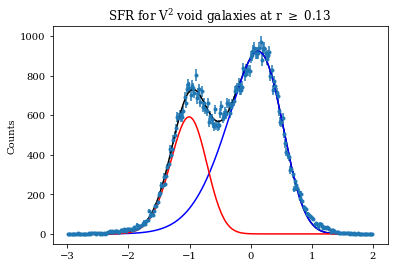

[ 1.06895182e+03  4.90699436e-01  7.05661590e-01 -2.20188402e+00
  4.43180718e+02 -8.12895324e-01  3.73921898e-01 -1.09835725e+00] [2.42941267e+01 1.33314185e-02 3.49998536e-02 2.03039220e-01
 2.39252835e+01 1.93446312e-02 1.50838438e-02 1.97528885e-01]
115628


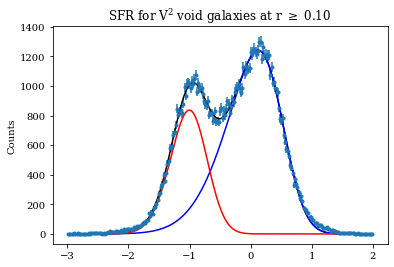

[ 1.43622224e+03  4.92101548e-01  7.03278566e-01 -2.17989844e+00
  6.29552439e+02 -8.10794551e-01  3.73229799e-01 -1.07412899e+00] [2.94193290e+01 1.20278627e-02 3.14427934e-02 1.80786071e-01
 2.89963550e+01 1.68744669e-02 1.28834055e-02 1.68244802e-01]
156341


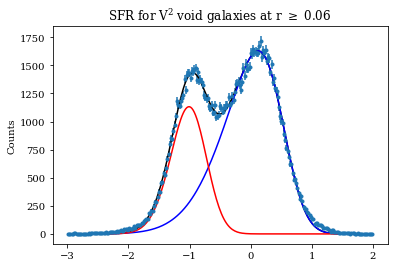

[ 1.97217014e+03  5.06492038e-01  7.55668372e-01 -2.41521291e+00
  8.32962891e+02 -8.14920305e-01  3.69943839e-01 -1.13021381e+00] [3.41644546e+01 9.08496731e-03 2.68217110e-02 1.55888582e-01
 3.31946479e+01 1.31303495e-02 1.06000535e-02 1.29197491e-01]
205744


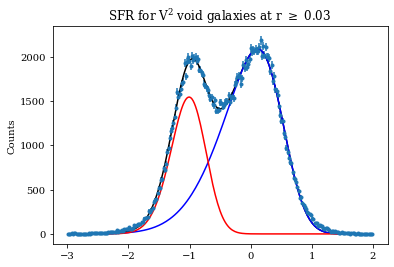

[ 2.59084752e+03  5.06751089e-01  7.80014601e-01 -2.47715413e+00
  1.11510771e+03 -8.09072282e-01  3.72566798e-01 -1.23524354e+00] [3.97110627e+01 7.99294430e-03 2.41770707e-02 1.39453525e-01
 3.82274358e+01 9.82501754e-03 8.77391770e-03 1.02337453e-01]
247281


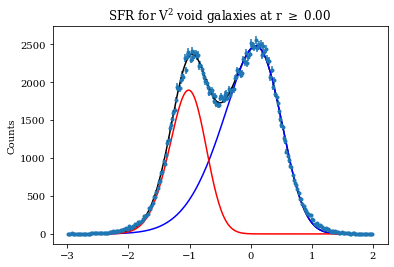

[ 3.02031144e+03  4.69848625e-01  7.41177978e-01 -2.19347411e+00
  1.43329204e+03 -8.07180237e-01  3.90227332e-01 -1.24483544e+00] [5.46716120e+01 1.03105520e-02 2.83163629e-02 1.51325297e-01
 5.36661964e+01 9.06284405e-03 7.98825377e-03 9.83766197e-02]


In [43]:
# Number of slices
N = 10

# Volume of inner-most slice (r = 0.5)
r_in = 0.5
V_in = r_in**3 # Normalized by 4/3*pi, since this is the volume of the entire volume

# volume-spacing
d_vol = (4./3.)*np.pi*(1 - V_in)/N

# Initialize variable that will store the previous radius value
r_limits = np.zeros(N+1, dtype=float)
r_limits[0] = r_in

# Initialize arrays that will store the ratios and uncertainties
SFR_ratio_V2 = -1*np.ones(N+1, dtype=float)
SFR_ratio_V2_err = np.zeros(N+1, dtype=float)

for i in range(N + 1):
    
    # Calculate minimum radius of this slice
    if i != 0:
        r_limits[i] = 1 - ((1 - r_limits[i - 1])**3 + (3*d_vol/(4*np.pi)))**(1./3.)
    
    # Select all V2 void galaxies with normalized void depths greater than or equal to this value
    gals_in = (catalog_main['V2_depth'] >= r_limits[i]) & void_v2
    print(np.sum(gals_in))
    
    # Fit this distribution
    SFR_V2slice_fit = fit_bimodal(char_=catalog_main['SFR'], 
                                  class_=gals_in, 
                                  bins=SFR_bins, 
                                  p0_=[50, 0.5, 0.75, -2.25, 70, -0.75, 0.5, -1.5], 
                                  label=r'SFR for V$^2$ void galaxies at r $\geq$ {:.2f}'.format(r_limits[i]))
    
    # Calculate local maxima
    blue = minimize_scalar(lambda x: -func_bimodal(x, *SFR_V2slice_fit[0]), 
                           bounds=(-0.5,2), 
                           method='bounded')
    red = minimize_scalar(lambda x: -func_bimodal(x, *SFR_V2slice_fit[0]), 
                          bounds=(-2, -0.5), 
                          method='bounded')
    
    # Calculate ratio uncertainty
    SFR_ratio_V2[i], SFR_ratio_V2_err[i] = ratio_uncertainty_approx(SFR_V2slice_fit[0], 
    #SFR_ratio_V2_err[i] = ratio_uncertainty(SFR_V2slice_fit[0], 
                                                                    SFR_V2slice_fit[1], 
                                                                    blue.x, 
                                                                    red.x)
    
    # Calculate ratio
    SFR_ratio_V2[i] = blue.fun/red.fun

247281


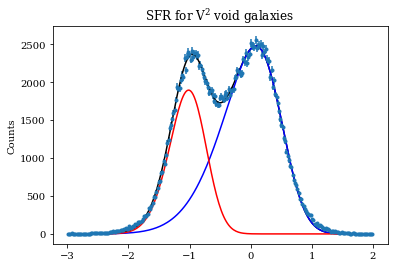

[ 3.02030637e+03  4.69847727e-01  7.41175312e-01 -2.19346023e+00
  1.43329712e+03 -8.07179956e-01  3.90227609e-01 -1.24483229e+00] [5.46721937e+01 1.03108436e-02 2.83167511e-02 1.51326841e-01
 5.36668587e+01 9.06288350e-03 7.98822558e-03 9.83775683e-02]


In [21]:
print(np.sum(void_v2))
SFR_V2_fit = fit_bimodal(char_=catalog_main['SFR'],
                         class_=void_v2,
                         bins=SFR_bins, 
                         p0_=[4000, 0.5, 0.75, -2.25, 2000, -0.75, 0.5, -1.5], 
                         label='SFR for V$^2$ void galaxies')

## Plot results

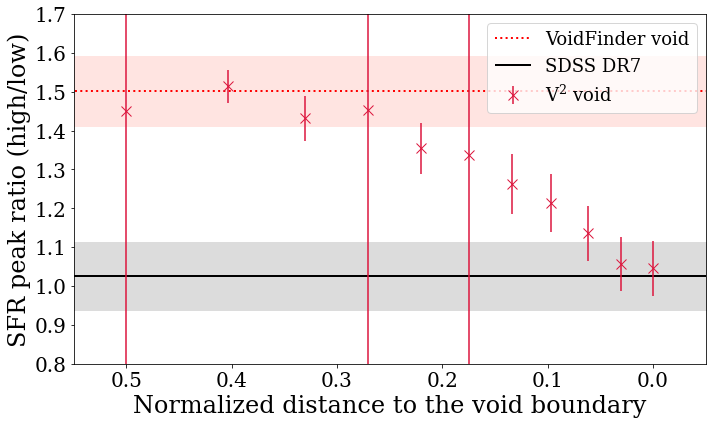

In [22]:
plt.figure(figsize=(10,6), tight_layout=True)

# VoidFinder
plt.fill_between([-0.1, 0.55], 
                 [SFR_ratio_VF + SFR_ratio_VF_err], 
                 [SFR_ratio_VF - SFR_ratio_VF_err], 
                 color='mistyrose')
plt.hlines(SFR_ratio_VF, -0.1, 0.55, colors='r', linestyle='dotted', linewidth=2, label='VoidFinder void')

# All
plt.fill_between([-0.1, 0.55], 
                 [SFR_ratio_all + SFR_ratio_all_err], 
                 [SFR_ratio_all - SFR_ratio_all_err], 
                 color='gainsboro')
plt.hlines(SFR_ratio_all, -0.1, 0.55, colors='k', linewidth=2, label='SDSS DR7')

# V2
plt.errorbar(r_limits, 
             SFR_ratio_V2, 
             yerr=SFR_ratio_V2_err, 
             fmt='x', 
             color='crimson', 
             markersize=10, 
             label='V$^2$ void')
# plt.plot(r_limits, SFR_ratio_V2, '.', color='crimson', markersize=10, label='V$^2$ void')
# plt.fill_between(r_limits, 
#                  SFR_ratio_V2 + SFR_ratio_V2_err, 
#                  SFR_ratio_V2 - SFR_ratio_V2_err, 
#                  color='crimson', 
#                  alpha=0.1)

plt.xlabel('Normalized distance to the void boundary', fontsize=24)
plt.ylabel('SFR peak ratio (high/low)', fontsize=24)

plt.xlim(0.55, -0.05)
plt.ylim(0.8, 1.7)

plt.legend(fontsize=18)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

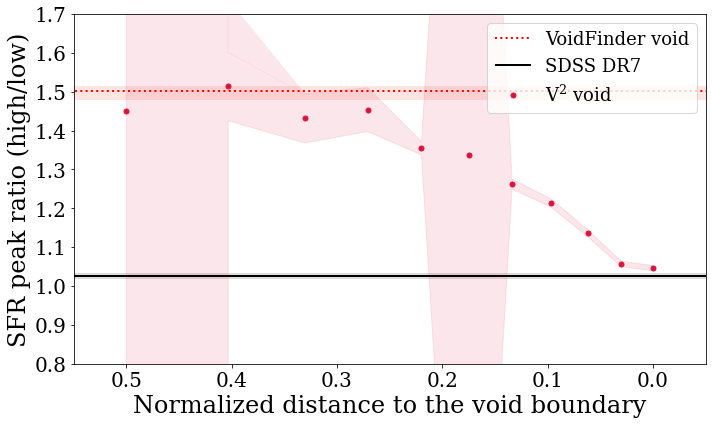

In [38]:
plt.figure(figsize=(10,6), tight_layout=True)

# VoidFinder
plt.fill_between([-0.1, 0.55], 
                 [SFR_ratio_VF_approx + SFR_ratio_VF_err], 
                 [SFR_ratio_VF_approx - SFR_ratio_VF_err], 
                 color='mistyrose')
plt.hlines(SFR_ratio_VF, -0.1, 0.55, colors='r', linestyle='dotted', linewidth=2, label='VoidFinder void')

# All
plt.fill_between([-0.1, 0.55], 
                 [SFR_ratio_all_approx + SFR_ratio_all_err], 
                 [SFR_ratio_all_approx - SFR_ratio_all_err], 
                 color='gainsboro')
plt.hlines(SFR_ratio_all, -0.1, 0.55, colors='k', linewidth=2, label='SDSS DR7')

# V2
# plt.errorbar(r_limits, 
#              SFR_ratio_V2, 
#              yerr=SFR_ratio_V2_err, 
#              fmt='x', 
#              color='crimson', 
#              markersize=10, 
#              label='V$^2$ void')
plt.plot(r_limits, SFR_ratio_V2, '.', color='crimson', markersize=10, label='V$^2$ void')
plt.fill_between(r_limits, 
                 SFR_ratio_V2 + SFR_ratio_V2_err, 
                 SFR_ratio_V2 - SFR_ratio_V2_err, 
                 color='crimson', 
                 alpha=0.1)

plt.xlabel('Normalized distance to the void boundary', fontsize=24)
plt.ylabel('SFR peak ratio (high/low)', fontsize=24)

plt.xlim(0.55, -0.05)
plt.ylim(0.8, 1.7)

plt.legend(fontsize=18)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

In [30]:
SFR_ratio_V2

array([1.45130282, 1.51334417, 1.43136875, 1.45376819, 1.35464837,
       1.3379279 , 1.26237142, 1.21337457, 1.13580577, 1.05683203,
       1.04597497])

In [31]:
SFR_ratio_V2_err

array([6.52806257e+29, 8.80542515e-02, 6.33860129e-02, 5.64027426e-02,
       1.73761981e-02, 1.96675271e+00, 1.28736337e-02, 1.06949250e-02,
       8.93249390e-03, 7.19899696e-03, 6.64468809e-03])